# Imports & variable definitions

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
import os

In [30]:
country_set = ['South Africa', 'Nigeria', 'India', 'China', 'Japan', 
               'South Korea', 'Germany', 'Poland', 'France', 'United Kingdom', 
               'Finland', 'Brazil', 'Argentina', 'Colombia', 'Saudi Arabia', 'Iran', 
               'Afghanistan', 'United States', 'Canada', 'Mexico']

# Happiness data input and preprocessing

In [31]:
# Read in data
happiness_data = {}

for f in os.listdir('../data/WHI/'):
    year = f.split('.')[0]
    happiness_data[year] = pd.read_csv('../data/WHI/' + f)

# Unify column names
happiness_data['2017'].rename(columns={'Happiness.Score': 'Happiness Score'}, inplace=True)

happiness_data['2018'].rename(columns={'Country or region':'Country',
                        'Score':'Happiness Score'}, inplace=True)
happiness_data['2019'].rename(columns={'Country or region':'Country',
                        'Score':'Happiness Score'}, inplace=True)

happiness_data['2020'].rename(columns={'Country name': 'Country',
                        'Ladder score':'Happiness Score'}, inplace=True)
happiness_data['2021'].rename(columns={'Country name': 'Country',
                        'Ladder score':'Happiness Score'}, inplace=True)

happiness_data['2022'].rename(columns={'Happiness score': 'Happiness Score'}, inplace=True)

# Change number format for 2022 data to match other data
happiness_data['2022']['Happiness Score'] = happiness_data['2022']['Happiness Score'].str.replace(',', '.').astype(float)

# Remove every column except Country, Region and Happiness Score and add a column for the year
for df in happiness_data:
    happiness_data[df] = happiness_data[df][['Country', 'Happiness Score']]
    happiness_data[df]['Year'] = df

# Merge all years in one frame
happiness_df = pd.concat(happiness_data, ignore_index=True)

happiness_df

,Country,Happiness Score,Year
0,Switzerland,7.587,2015
1,Iceland,7.561,2015
2,Denmark,7.527,2015
3,Norway,7.522,2015
4,Canada,7.427,2015
...,...,...,...
1226,Benin,3.484,2016
1227,Afghanistan,3.360,2016
1228,Togo,3.303,2016
1229,Syria,3.069,2016


In [32]:
# Remove invalid countries
happiness_df.drop(happiness_df.loc[happiness_df['Country'] == 'xx'].index, inplace=True)

# Sort by year
happiness_df.sort_values(by=['Year'], inplace=True)

# Filter to only include the countries we want to predict
happiness_df = happiness_df[happiness_df['Country'].isin(country_set)]

happiness_df.head()

,Country,Happiness Score,Year
112,South Africa,4.642,2015
116,India,4.565,2015
109,Iran,4.686,2015
83,China,5.140,2015
152,Afghanistan,3.575,2015


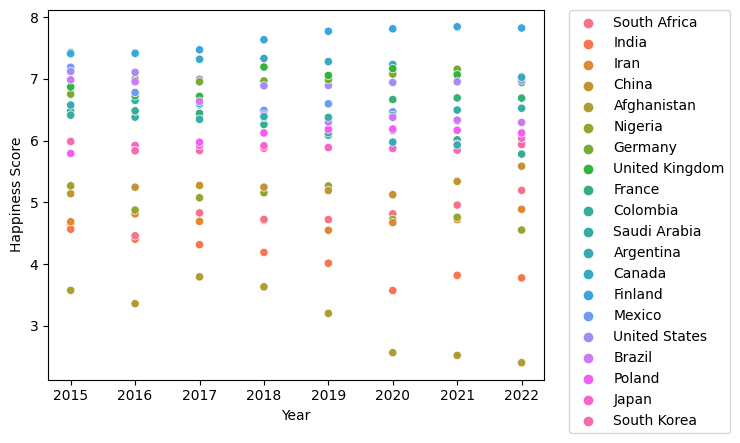

In [34]:
# Plot data for each country
hp_plt = sns.scatterplot(data=happiness_df, x='Year', y='Happiness Score', hue='Country')
hp_plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

In [8]:
#rng = np.random.RandomState(42) #Beispieldaten aus zwei Schwingungen
#x = 10 * rng.rand(200)

#def model(x, sigma=0.3):
#    fast_oscillation = np.sin(5 * x)
#    slow_oscillation = np.sin(0.5 * x)
#    noise = sigma * rng.randn(len(x))
#
#    return slow_oscillation + fast_oscillation + noise

#y = model(x)
#plt.errorbar(x, y, 0.3, fmt='o'); # Konfidenzintervall

## Enrich happiness data

### Human rights data

In [19]:
hr_df = pd.read_csv('../data/human_rights.csv')

# Filter to 2015-2021
hr_df = hr_df.loc[hr_df['Year'].isin(range(2015, 2022))]

# Drop and rename columns
hr_df.drop(columns=['Code', 'region'], inplace=True)
hr_df.rename(columns={'Entity': 'Country', 'civ_libs_vdem_owid':'Human Rights Score'}, inplace=True)

# Filter to country set
hr_df = hr_df[hr_df['Country'].isin(country_set)]

hr_df.head()

,Country,Year,Human Rights Score
10268,France,2015,0.951
10269,France,2016,0.951
10270,France,2017,0.951
10271,France,2018,0.949
10272,France,2019,0.944


# Data analysis with Random Forest Regressor

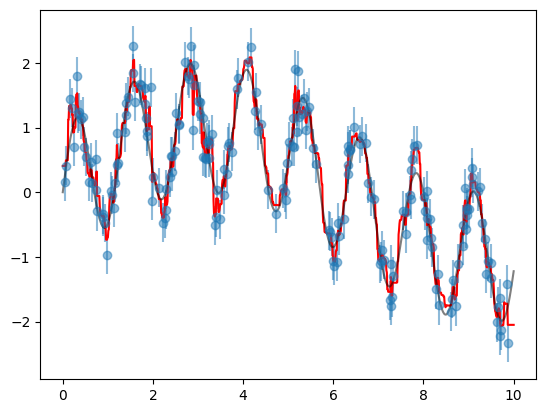

In [3]:
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(200) # Number of decision trees
forest.fit(x[:, None], y)

xfit = np.linspace(0, 10, 1000)
yfit = forest.predict(xfit[:, None])
ytrue = model(xfit, sigma=0)

plt.errorbar(x, y, 0.3, fmt='o', alpha=0.5)
plt.plot(xfit, yfit, '-r');
plt.plot(xfit, ytrue, '-k', alpha=0.5);